#### 크롭된 이미지로 학습 진행 => 한글자씩 나누어져 있는 데이터를 먼저 학습하기

In [1]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import random_split

from torchmetrics.classification import accuracy
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import os
import json

In [ ]:
path = './data/handwrite_label/'
nums = os.listdir(path)
for num in nums:
    files = os.listdir(path+num)
    for file in files:
        print(path+num+'/'+file)

### json 파일 형태
![스크린샷 2024-10-28 184633 - 복사본.png](<attachment:스크린샷 2024-10-28 184633 - 복사본.png>)
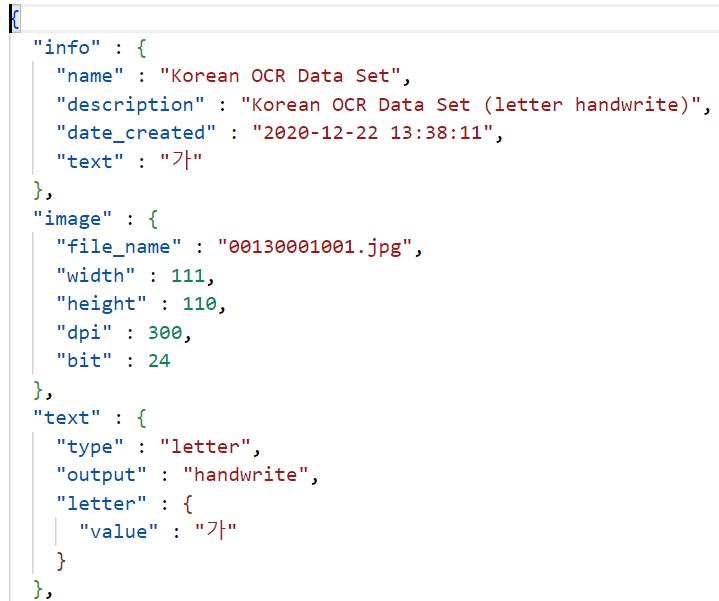

In [13]:
# json파일 읽어서 새로운 폴더에 사진 저장 (이미지 폴더 만들기 위해서!)
df_list = []
path = './data/handwrite_label/'
nums = os.listdir(path)
for num in nums:
    files = os.listdir(path+num)
    for file in files:
        with open(path+num+'/'+file,'r') as f:
            data = json.load(f)
            # 이미지 파일 이름과 라벨을 담아서 데이터 프레임으로 만들기
            image = data['image']['file_name']
            text = data['info']['text']
            
            data_list = []
            data_list.append(num+'/'+image)
            data_list.append(text)

            df_list.append(data_list)

In [ ]:
dataDF = pd.DataFrame(df_list, columns=['image_path', 'label'])
dataDF

In [15]:
dataDF.to_csv('letter.csv', index=False)

In [ ]:
labels = dataDF['label'].unique().tolist()
len(labels)

In [20]:
# # 각 글자 이름의 폴더 생성
# for label in labels:
#     os.mkdir(f"./letter/{label}")

In [25]:
# # 이미지 읽어서 저장하기 (라벨명이 담긴 폴더에 하나씩 저장)
# file_path = './data/handwrite_image/'
# for i in range(2):
#     img_path = file_path+dataDF['image_path'][i]
#     img = Image.open(img_path)
#     img.save(f"./letter/{dataDF['label'][i]}/{dataDF['image_path'][i][:3]}"+'.jpg')

In [26]:
# # 이미지 읽어서 저장하기
# file_path = './data/handwrite_image/'
# for i in range(len(dataDF)):
#     img_path = file_path+dataDF['image_path'][i]
#     img = Image.open(img_path)
#     img.save(f"./letter/{dataDF['label'][i]}/{dataDF['image_path'][i][:3]}"+'.jpg')

In [ ]:
dataDF[dataDF['label']=='갈']

### 학습 진행

In [2]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

- 이미지 데이터셋 생성
---

In [3]:
IMG_PATH = './letter/'

In [4]:
transConvert = transforms.Compose([transforms.Resize([256]), transforms.CenterCrop(224),transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
# 이미지 데이터셋 생성
imgDS = ImageFolder(root=IMG_PATH, transform=transConvert)

In [6]:
print(f'imgDS.classes : {imgDS.classes}')
print(f'imgDS.class_to_idx : {imgDS.class_to_idx}')
print(f'imgDS.targets : {imgDS.targets}')

imgDS.classes : ['가', '각', '간', '갇', '갈', '갉', '갊', '감', '갑', '값', '갓', '갔', '강', '갖', '갗', '같', '갚', '갛', '개', '객', '갠', '갤', '갬', '갭', '갯', '갰', '갱', '갸', '갹', '갼', '걀', '걋', '걍', '걔', '걘', '걜', '거', '걱', '건', '걷', '걸', '걺', '검', '겁', '것', '겄', '겅', '겆', '겉', '겊', '겋', '게', '겐', '겔', '겜', '겝', '겟', '겠', '겡', '겨', '격', '겪', '견', '겯', '결', '겸', '겹', '겻', '겼', '경', '곁', '계', '곈', '곌', '곕', '곗', '고', '곡', '곤', '곧', '골', '곪', '곬', '곯', '곰', '곱', '곳', '공', '곶', '과', '곽', '관', '괄', '괆', '괌', '괍', '괏', '광', '괘', '괜', '괠', '괩', '괬', '괭', '괴', '괵', '괸', '괼', '굄', '굅', '굇', '굉', '교', '굔', '굘', '굡', '굣', '구', '국', '군', '굳', '굴', '굵', '굶', '굻', '굼', '굽', '굿', '궁', '궂', '궈', '궉', '권', '궐', '궜', '궝', '궤', '궷', '귀', '귁', '귄', '귈', '귐', '귑', '귓', '규', '균', '귤', '그', '극', '근', '귿', '글', '긁', '금', '급', '긋', '긍', '긔', '기', '긱', '긴', '긷', '길', '긺', '김', '깁', '깃', '깅', '깆', '깊', '까', '깍', '깎', '깐', '깔', '깖', '깜', '깝', '깟', '깠', '깡', '깥', '깨', '깩', '깬', '깰', '깸', '깹', '깻', '깼', '깽', '꺄', '꺅', '꺌', '꺼', '꺽'

In [7]:
len(imgDS)

276886

In [8]:
# train, validation 분리
trainDS, validDS = random_split(imgDS,[0.8,0.2])

trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
validDL = DataLoader(validDS, batch_size=32, shuffle=False)

In [9]:
## 전이학습 모델 로딩
model = models.resnet101(weights = models.ResNet101_Weights.IMAGENET1K_V1)

In [10]:
## 모델 구조 확인
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
## 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    # 역전파시 업데이트 되지 않도록 설정
    param.requires_grad = False

In [12]:
model.fc = nn.Linear(2048,2350)

In [13]:
# fc 파라미터 활성화 설정
for named, param in model.fc.named_parameters():
    print(f'[{named}] = {param.shape}')
    param.requires_grad = True

[weight] = torch.Size([2350, 2048])
[bias] = torch.Size([2350])


In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
model = model.to(DEVICE)

In [16]:
## 학습 진행 관련 설정
EPOCH = 10
BATCH_SIZE = 32
LR = 0.001

In [17]:
# 최적화 인스턴스
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스
crossLoss = nn.CrossEntropyLoss().to(DEVICE)

# 최적화 스케줄링 인스턴스 생성
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

c:\Users\kdp\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# 저장 경로
SAVE_PATH = './models/'
# 저장 파일명
SAVE_FILE = SAVE_PATH+'model_train_wb.pth'

# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL = SAVE_PATH+'model_all.pth'

In [19]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH) : os.makedirs(SAVE_PATH)   # 폴더 / 폴더 / ...  하위폴더까지 생성

In [ ]:
loss_history = [[],[]]
f1score_history= [[],[]]
accuracy_history = [[],[]]

for epoch in range(EPOCH):
    print(f'[EPOCH {epoch+1}/{EPOCH}]')
    print('-'*50)

    # 학습 모드로 모델 설정
    model.train()

    # 배치크기만큼 데이터 로딩 후 학습 진행
    train_loss, train_score, train_acc = 0,0,0
    # 데이터로더에 전달된 데이터만큼 반복
    for features, targets in trainDL:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        outputs = model(features)

        loss = crossLoss(outputs, targets).to(DEVICE)
        train_loss += loss.item()

        score = MulticlassF1Score(num_classes=2350).to(DEVICE)(outputs, targets)
        train_score += score.item()

        accuracy = MulticlassAccuracy(num_classes=2350).to(DEVICE)(outputs,targets)
        train_acc += accuracy.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ## 에포크 당 검증
    # 검증모드로 모델 설정
    model.eval()
    valid_loss, valid_score, val_acc = 0,0,0
    with torch.no_grad():
        # 배치크기만큼 데이터 로딩 후 학습 진행
        # 데이터로더에 전달된 데이터만큼 반복
        for features, targets in validDL:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            pre_val = model(features)

            loss = crossLoss(pre_val, targets)
            valid_loss += loss.item()

            score = MulticlassF1Score(num_classes=2350).to(DEVICE)(pre_val, targets)
            valid_score += score.item()

            accuracy = MulticlassAccuracy(num_classes=2350).to(DEVICE)(pre_val,targets)
            val_acc += accuracy.item()

    # 에포크 당 손실과 성능 평가 값 저장
    loss_history[0].append(train_loss/len(trainDL))
    f1score_history[0].append(train_score/len(trainDL))
    accuracy_history[0].append(train_acc/len(trainDL))

    loss_history[1].append(valid_loss/len(validDL))
    f1score_history[1].append(valid_score/len(validDL))
    accuracy_history[1].append(val_acc/len(validDL))
   

    print(f'- [TRAIN] LOSS : {loss_history[0][-1]} F1SCORE : {f1score_history[0][-1]} ACCURACY : {accuracy_history[0][-1]}')
    print(f'- [VALID] LOSS : {loss_history[1][-1]} F1SCORE : {f1score_history[1][-1]} ACCURACY : {accuracy_history[1][-1]}')

    scheduler.step(accuracy_history[1][-1])
    print(f'scheduler.num_bad_epochs : {scheduler.num_bad_epochs}')

    # 성능이 좋은 학습 가중치 저장
    avg_train_loss = train_loss/len(trainDL)
    avg_train_score = train_score/len(trainDL)

    SAVE_MODEL = SAVE_PATH+ f'loss_{avg_train_loss:.3f}_score{avg_train_score:.3f}.pth'

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wb{epoch}_{score_val:.2f}.pth'  # 성능이 좋아진 에포크, 스코어마다 파일 새로 저장
    if len(accuracy_history[2]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_MODEL)
    else :
        if accuracy_history[1][-1] > max(accuracy_history[1][:-1]) :
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)

    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'성능 개선이 없어서 {scheduler.patience} EPOCH에 조기 종료함!')
        break

[EPOCH 1/10]
--------------------------------------------------
